# Plot cross-contour heat transport

First year, monthly data, compare control to UP.

Heat transport is calculated in `compute_online_cross_slope_heat_transport_binned_terms_1000m_isobath.ipynb`

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import xgcm
import xarray.ufuncs as xu

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39431/status,
Dashboard: /proxy/39431/status,Workers: 4
Total threads: 4,Total memory: 11.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37751,Workers: 4
Dashboard: /proxy/39431/status,Total threads: 4
Started: Just now,Total memory: 11.23 GiB
Comm: tcp://10.0.128.134:43049,Total threads: 1
Dashboard: /proxy/36465/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:33625,


In [3]:
file_path = '/g/data/x77/wgh581/Post_Process/easterlies_hackathon_postprocess/'
control   = xr.open_dataset(file_path + 'Ant_cross_slope_heat_terms_online_1000m_2150-2150_control.nc')
UP        = xr.open_dataset(file_path + 'Ant_cross_slope_heat_terms_online_1000m_2150-2150_UP.nc')
DOWN      = xr.open_dataset(file_path + 'Ant_cross_slope_heat_terms_online_1000m_2150-2150_DOWN.nc')

In [4]:
control

<xarray.Dataset>
Dimensions:                    (time: 12, lon_bin_midpoints: 1428, lat_bin_midpoints: 1428, lon_along_contour: 6002)
Coordinates:
  * time                       (time) object 2150-01-16 12:00:00 ... 2150-12-...
  * lon_bin_midpoints          (lon_bin_midpoints) float64 -278.5 ... 78.25
  * lat_bin_midpoints          (lat_bin_midpoints) float64 -65.63 ... -66.49
  * lon_along_contour          (lon_along_contour) float64 -279.9 ... 80.0
Data variables:
    zonal_convergence          (time, lon_bin_midpoints) float64 ...
    cross_slope_heat_trans     (time, lon_bin_midpoints) float64 ...
    bin_width                  int64 ...
    bin_spacing                float64 ...
    heat_trans_across_contour  (time, lon_along_contour) float64 ...

In [4]:
# Extract arrays
control_cross_binned = control.cross_slope_heat_trans
control_zonal_binned = control.zonal_convergence
control_unbinned     = control.heat_trans_across_contour

UP_cross_binned = UP.cross_slope_heat_trans
UP_zonal_binned = UP.zonal_convergence
UP_unbinned     = UP.heat_trans_across_contour

DOWN_cross_binned = DOWN.cross_slope_heat_trans
DOWN_zonal_binned = DOWN.zonal_convergence
DOWN_unbinned     = DOWN.heat_trans_across_contour

In [5]:
# Scaling so circumpolar integral matches the unbinned heat transport
control_scale = np.sum(control_unbinned, axis=1) / np.sum(control_cross_binned, axis=1)
UP_scale = np.sum(UP_unbinned, axis=1) / np.sum(UP_cross_binned, axis=1)
DOWN_scale = np.sum(DOWN_unbinned, axis=1) / np.sum(UP_cross_binned, axis=1)

control_cross_binned_scaled = control_cross_binned * control_scale
control_zonal_binned_scaled = control_zonal_binned * control_scale

UP_cross_binned_scaled = UP_cross_binned * UP_scale
UP_zonal_binned_scaled = UP_zonal_binned * UP_scale

DOWN_cross_binned_scaled = DOWN_cross_binned * DOWN_scale
DOWN_zonal_binned_scaled = DOWN_zonal_binned * DOWN_scale

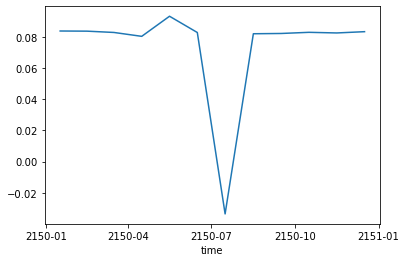

In [9]:
# July looks off, signs of unbinned and binned product opposite.
control_scale.plot()

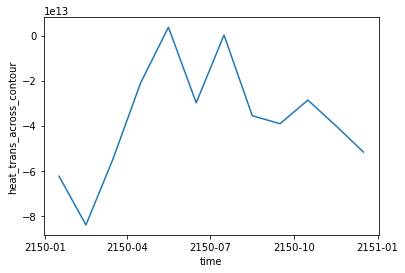

In [10]:
control_unbinned.sum('lon_along_contour').plot()

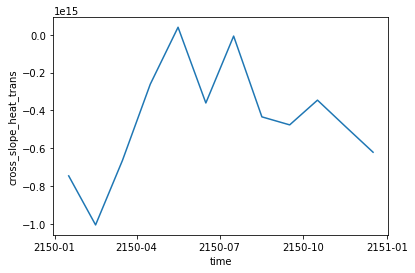

In [12]:
control_cross_binned.sum('lon_bin_midpoints').plot()

In [13]:
print(control_cross_binned.sum('lon_bin_midpoints').values)
print(control_unbinned.sum('lon_along_contour').values)

[-7.45690868e+14 -1.00476597e+15 -6.63805483e+14 -2.61524560e+14
  3.95584284e+13 -3.60525055e+14 -7.16823984e+12 -4.33896590e+14
 -4.76276265e+14 -3.45575962e+14 -4.84027641e+14 -6.20724518e+14]
[-6.24634518e+13 -8.40629269e+13 -5.49832429e+13 -2.10107741e+13
  3.68838355e+12 -2.98527971e+13  2.41107945e+11 -3.55803685e+13
 -3.91409806e+13 -2.86544828e+13 -3.99391169e+13 -5.17276048e+13]


In [14]:
control_scale.values

array([ 0.08376588,  0.08366419,  0.08283035,  0.08033958,  0.09323888,
        0.08280367, -0.03363559,  0.08200195,  0.08218125,  0.08291804,
        0.08251412,  0.08333424])

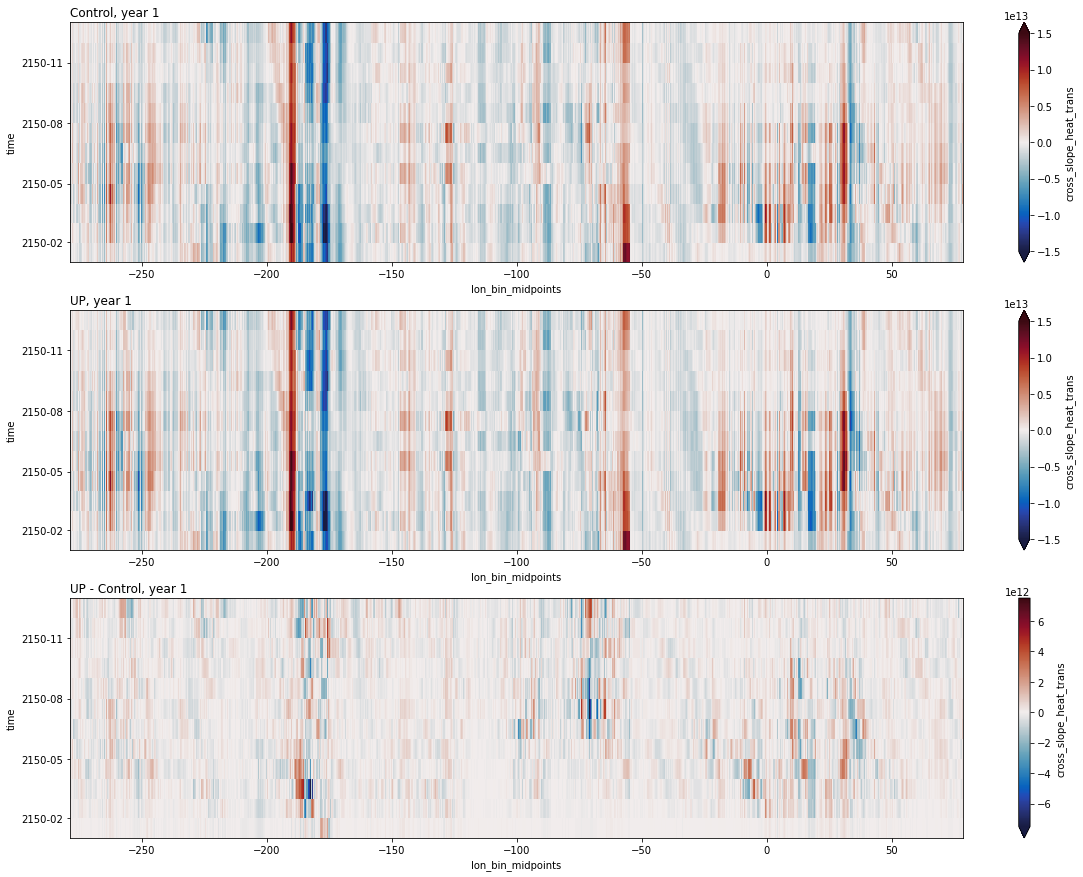

In [5]:
# Unscaled (I get weird value for one month as values are +ve for one file and -ve for the other)

fig = plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
plt.title('Control, year 1', loc='left')
control_cross_binned.plot(cmap=cmocean.balance, vmin=-1.5e13, vmax=1.5e13)

plt.subplot(3,1,2)
plt.title('UP, year 1', loc='left')
UP_cross_binned.plot(cmap=cmocean.balance, vmin=-1.5e13, vmax=1.5e13)

plt.subplot(3,1,3)
plt.title('UP - Control, year 1', loc='left')
(UP_cross_binned-control_cross_binned).plot(cmap=cmocean.balance, vmin=-0.75e13, vmax=0.75e13);

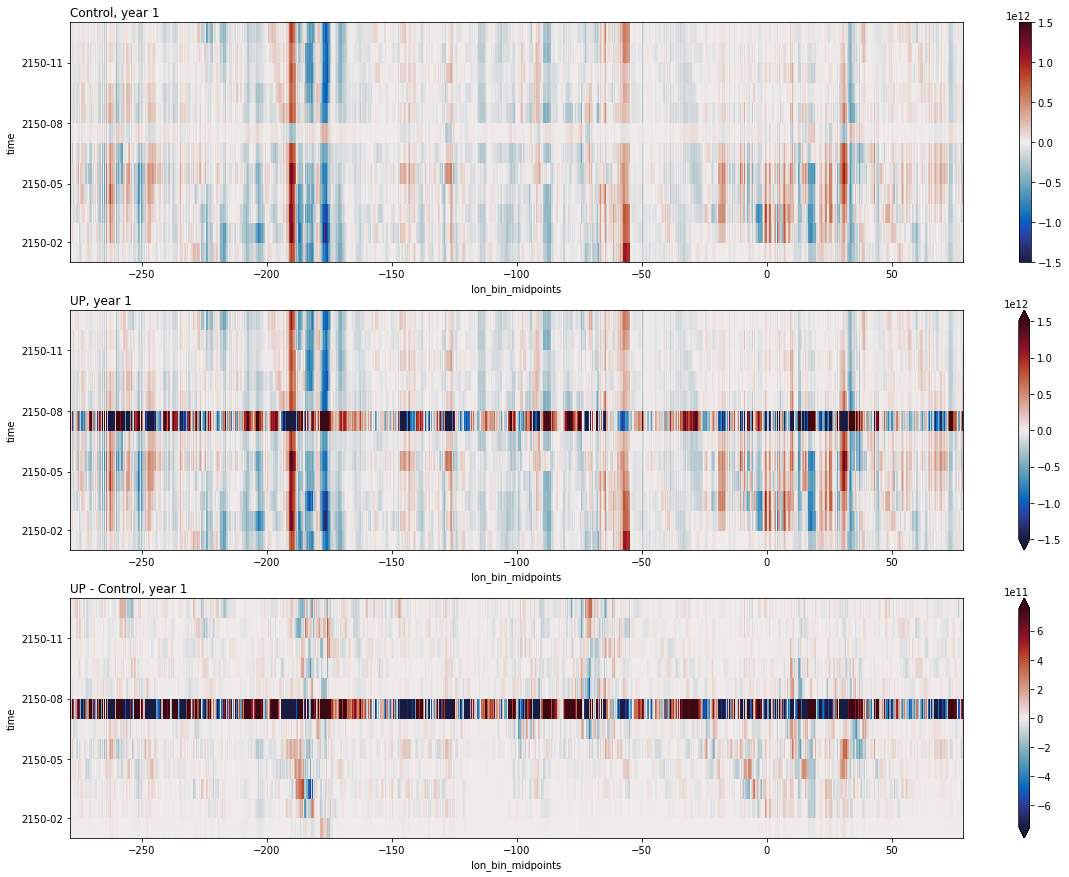

In [18]:
# Scaled

fig = plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
plt.title('Control, year 1', loc='left')
control_cross_binned_scaled.plot(cmap=cmocean.balance, vmin=-1.5e12, vmax=1.5e12)

plt.subplot(3,1,2)
plt.title('UP, year 1', loc='left')
UP_cross_binned_scaled.plot(cmap=cmocean.balance, vmin=-1.5e12, vmax=1.5e12)

plt.subplot(3,1,3)
plt.title('UP - Control, year 1', loc='left')
(UP_cross_binned_scaled-control_cross_binned_scaled).plot(cmap=cmocean.balance, vmin=-0.75e12, vmax=0.75e12);

In [6]:
# Total heat transport = cross-isobath + zonal transport
control_total = control_cross_binned + control_zonal_binned
UP_total      = UP_cross_binned + UP_zonal_binned
DOWN_total    = DOWN_cross_binned + DOWN_zonal_binned

In [7]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig_path = '/g/data/x77/wgh581/Figures/Easterlies-Collab/'

# Font size
plt.rcParams['font.size'] = 16
# Axes
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Saving parameters
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

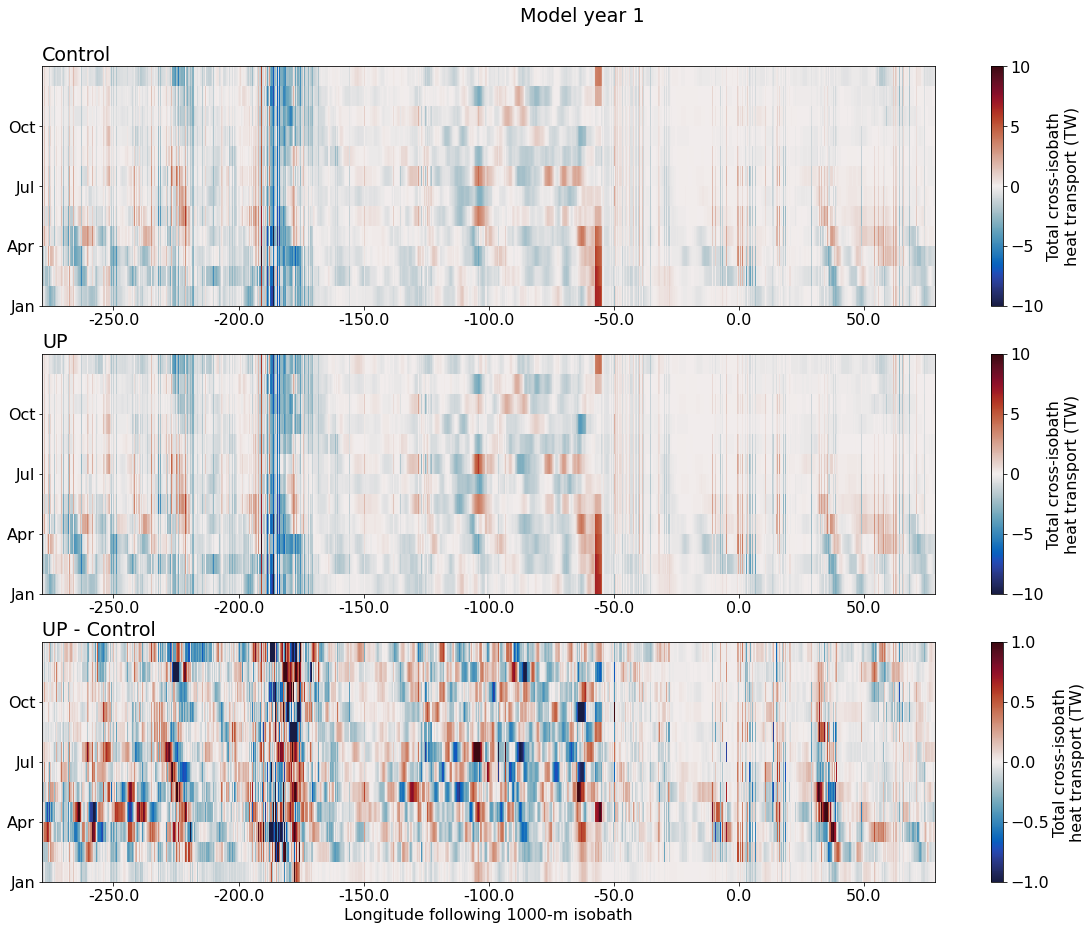

In [21]:
# Unscaled (I get weird value for one month as values are +ve for one file and -ve for the other)

fig = plt.figure(figsize=(20,15))

plt.suptitle('Model year 1', y=0.935)

plt.subplot(3,1,1)
plt.title('Control', loc='left')
plt.pcolormesh(control_total * 1e-12, cmap=cmocean.balance, vmin=-10, vmax=10)
cbar = plt.colorbar()
cbar.set_label('Total cross-isobath\nheat transport (TW)')
plt.xticks(ticks=np.arange(114, len(control_total.lon_bin_midpoints), 200), labels=control_total.lon_bin_midpoints[114::200].values)
plt.yticks(ticks=np.arange(0, 12, 3), labels=month[::3])
#(control_cross_binned+control_zonal_binned).plot(cmap=cmocean.balance)#, vmin=-1.5e13, vmax=1.5e13)

plt.subplot(3,1,2)
plt.title('UP', loc='left')
plt.pcolormesh(UP_total * 1e-12, cmap=cmocean.balance, vmin=-10, vmax=10)
cbar = plt.colorbar()
cbar.set_label('Total cross-isobath\nheat transport (TW)')
plt.xticks(ticks=np.arange(114, len(UP_total.lon_bin_midpoints), 200), labels=UP_total.lon_bin_midpoints[114::200].values)
plt.yticks(ticks=np.arange(0, 12, 3), labels=month[::3])
#(UP_cross_binned+UP_zonal_binned).plot(cmap=cmocean.balance)#, vmin=-1.5e13, vmax=1.5e13)

plt.subplot(3,1,3)
plt.title('UP - Control', loc='left')
plt.pcolormesh((UP_total - control_total)  * 1e-12, cmap=cmocean.balance, vmin=-1, vmax=1)
cbar = plt.colorbar()
cbar.set_label('Total cross-isobath\nheat transport (TW)')
plt.xticks(ticks=np.arange(114, len(UP_total.lon_bin_midpoints), 200), labels=UP_total.lon_bin_midpoints[114::200].values)
plt.yticks(ticks=np.arange(0, 12, 3), labels=month[::3])
plt.xlabel('Longitude following 1000-m isobath');
#(UP_cross_binned+UP_zonal_binned - control_cross_binned-control_zonal_binned).plot(cmap=cmocean.balance)#, vmin=-0.75e13, vmax=0.75e13);

# Finished        
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_total_heat_transport_1000m_isobath_hovmoeller.png'
    plt.savefig(fig_path + fig_name)#, dpi=150, bbox_inches='tight', facecolor='white')

Cumulative sum (along-slope)

In [8]:
control_total_cumsum = control_total.cumsum('lon_bin_midpoints')
UP_total_cumsum = UP_total.cumsum('lon_bin_midpoints')
DOWN_total_cumsum = DOWN_total.cumsum('lon_bin_midpoints')

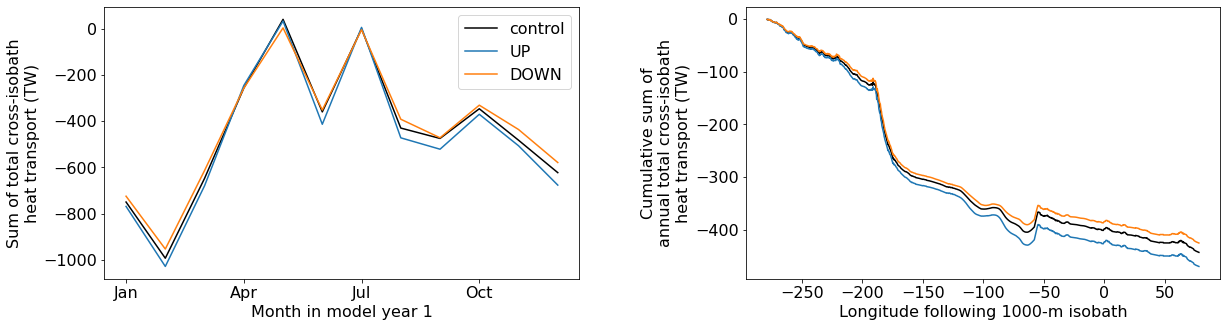

In [15]:
fig = plt.figure(figsize=(20, 5))

plt.subplot(121)
plt.plot(control_total_cumsum[:,-1] * 1e-12, color='k', label='control')
plt.plot(UP_total_cumsum[:,-1] * 1e-12, color='C0', label='UP')
plt.plot(DOWN_total_cumsum[:,-1] * 1e-12, color='C1', label='DOWN')
plt.legend()
plt.xlabel('Month in model year 1')
plt.ylabel('Sum of total cross-isobath\nheat transport (TW)')
plt.xticks(ticks=np.arange(0, 12, 3), labels=month[::3])

# Annual mean of cumulative transport
plt.subplot(122)
plt.plot(control_total_cumsum.lon_bin_midpoints, control_total_cumsum.mean('time')*1e-12, label='control', color='k')
plt.plot(UP_total_cumsum.lon_bin_midpoints, UP_total_cumsum.mean('time')*1e-12, label='UP', color='C0')
plt.plot(DOWN_total_cumsum.lon_bin_midpoints, DOWN_total_cumsum.mean('time')*1e-12, label='DOWN', color='C1')
#plt.legend()
plt.ylabel('Cumulative sum of\nannual total cross-isobath\nheat transport (TW)')
plt.xlabel('Longitude following 1000-m isobath')

plt.subplots_adjust(wspace=0.35)

# Finished        
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_total_heat_transport_1000m_isobath.png'
    plt.savefig(fig_path + fig_name)

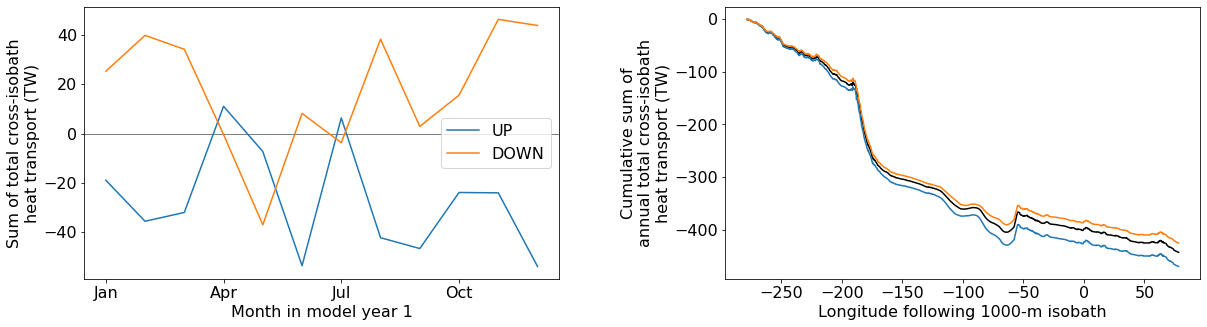

In [14]:
fig = plt.figure(figsize=(20, 5))

plt.subplot(121)
#plt.plot(control_total_cumsum[:,-1] * 1e-12, color='k', label='control')
plt.axhline(0, color='k', linewidth=0.5)
plt.plot(UP_total_cumsum[:,-1]*1e-12 - control_total_cumsum[:,-1]*1e-12, color='C0', label='UP')
plt.plot(DOWN_total_cumsum[:,-1]*1e-12 - control_total_cumsum[:,-1]*1e-12, color='C1', label='DOWN')
plt.legend()
plt.xlabel('Month in model year 1')
plt.ylabel('Sum of total cross-isobath\nheat transport (TW)')
plt.xticks(ticks=np.arange(0, 12, 3), labels=month[::3])

# Annual mean of cumulative transport
plt.subplot(122)
plt.plot(control_total_cumsum.lon_bin_midpoints, control_total_cumsum.mean('time')*1e-12, label='control', color='k')
plt.plot(UP_total_cumsum.lon_bin_midpoints, UP_total_cumsum.mean('time')*1e-12, label='UP', color='C0')
plt.plot(DOWN_total_cumsum.lon_bin_midpoints, DOWN_total_cumsum.mean('time')*1e-12, label='DOWN', color='C1')
#plt.legend()
plt.ylabel('Cumulative sum of\nannual total cross-isobath\nheat transport (TW)')
plt.xlabel('Longitude following 1000-m isobath')

plt.subplots_adjust(wspace=0.35)

# Finished        
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_total_heat_transport_1000m_isobath_anomaly.png'
    plt.savefig(fig_path + fig_name)

In [16]:
fig_path

'/g/data/x77/wgh581/Figures/Easterlies-Collab/'

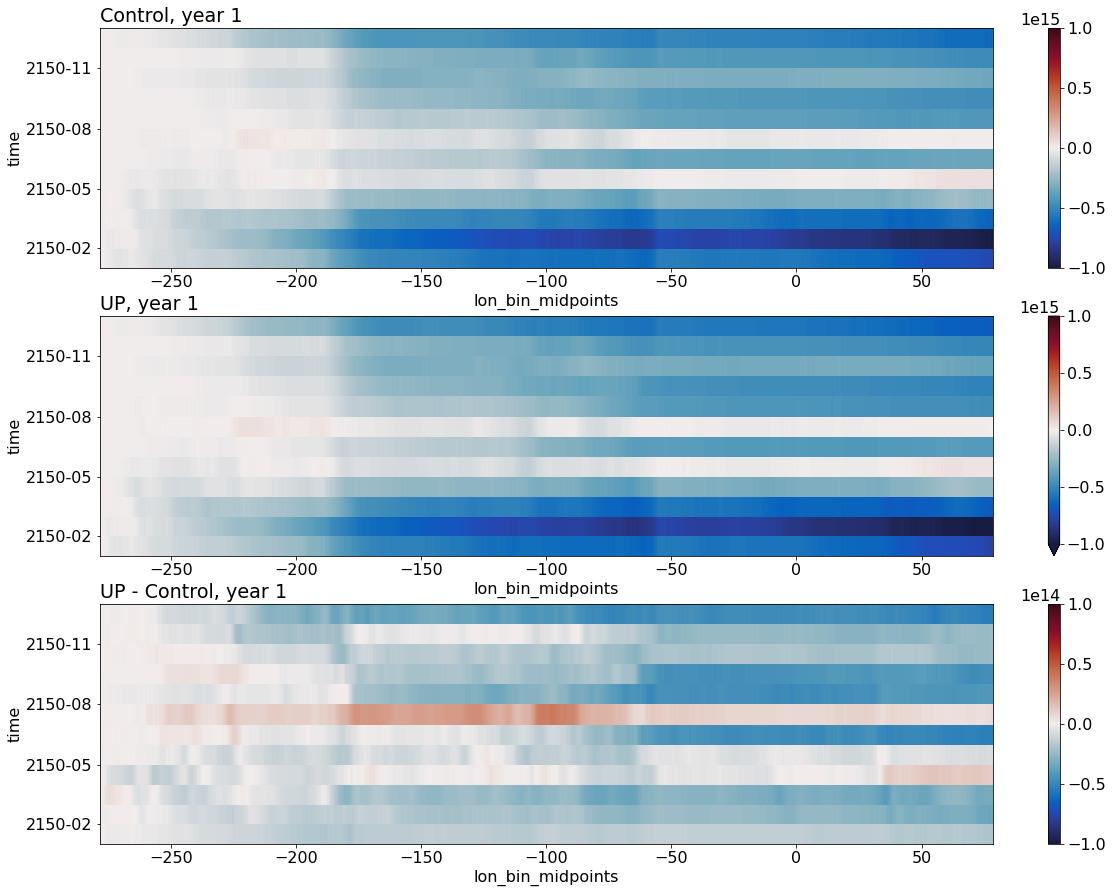

In [24]:
fig = plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
plt.title('Control, year 1', loc='left')
control_total_cumsum.plot(vmin=-1e15, vmax=1e15, cmap=cmocean.balance)
#(control.cross_slope_heat_trans+control.zonal_convergence).plot(cmap=cmocean.balance, vmin=-1.5e13, vmax=1.5e13)

plt.subplot(3,1,2)
plt.title('UP, year 1', loc='left')
UP_total_cumsum.plot(vmin=-1e15, vmax=1e15, cmap=cmocean.balance)
#(UP.cross_slope_heat_trans+UP.zonal_convergence).plot(cmap=cmocean.balance, vmin=-1.5e13, vmax=1.5e13)

plt.subplot(3,1,3)
plt.title('UP - Control, year 1', loc='left')
(UP_total_cumsum-control_total_cumsum).plot(vmin=-1e14, vmax=1e14, cmap=cmocean.balance)
#(UP.cross_slope_heat_trans+control.zonal_convergence-control.cross_slope_heat_trans-UP.zonal_convergence).plot(cmap=cmocean.balance, vmin=-0.75e13, vmax=0.75e13);